In [1]:
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dicts = pickle.load(fo, encoding='bytes')
        
    return dicts

In [3]:
def one_hot(Y_t, n_y):
    Y_hot = np.zeros((n_y,Y_t.shape[1]))
    Y_hot[Y, np.arange(Y_t.shape[1])] = 1
    return Y_hot

# Define neural network layers and units

In [4]:
def init_parameters(layer_dims):
    params = {}
    for l in range(1,len(layer_dims)):
        params["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        params["b"+str(l)] = np.zeros((layer_dims[l],1))
        
    return params

## Forward Propogation

In [5]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

#### Helper activation functions

In [30]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    
    return A, cache

def softmax(Z, axis=None):
    cache = Z
    Z = Z - Z.max(axis=axis, keepdims=True)
    y = np.exp(Z)
    return y / np.sum(y, axis=axis, keepdims=True), cache

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return a, cache

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "relu":
        Z, linear_cache  = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z,0)
    elif activation =="sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [8]:
def forward_prop(X, params):
    caches = list()
    A = X
    L = len(params) // 2 # no of paramaters divided by 2 w1 and b1 for no of layers
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        A, cache = linear_activation_forward(A, W, b, "relu")
        caches.append(cache)
    #final layer
    W = params["W"+str(L)]
    b = params["b"+str(L)]
    AL, cache = linear_activation_forward(A, W, b, "softmax")
    caches.append(cache)
    
    return AL, caches

## Compute Cost 

In [566]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    #logarithimic cost
#     cost = -(1/m)*np.sum((Y * np.log(AL) ) + ((1 - Y)*np.log(1-AL)))
    cost = -(1/m)*np.sum((Y * np.log(AL) ))
#     fsc = np.exp(AL)
#     rsc = fsc/np.sum(fsc,axis=1, keepdims=True)
#     tsc = -np.log(rsc[range(m),Y])
#     cost = (1/m)*np.sum(tsc)
    
    return cost

## Back Propogation

In [10]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [582]:
def relu_backward(dA, cache):
#     r,_ = relu(cache)
    return dA*(1. * (dA > 0))

def softmax_backward(dA, cache, y):
    s ,_ = softmax(cache)
    return s-y
#     return dA*(s*(1-s))

#     return dA * (1/dA.shape[1])
#     return dA-y
    
#     J = - s[..., None] * s[:, None, :]
#     iy, ix = np.diag_indices_from(J[0])
#     J[:, iy, ix] = s * (1. - s) # diagonal
#     p =  J.sum(axis=1) # sum across-rows for each sample
#     print(p)
#     return p

In [12]:
def linear_activation_backward(dA, cache, Y, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache, Y)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [568]:
def back_prop(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
#     dAL = (1/m)*(np.divide(Y, AL) + np.divide(1 - Y, 1 - AL))
    dAL = -(1/m)*np.divide(Y, AL)
#     dAL = -np.log(AL)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, Y, activation="softmax")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, Y, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [569]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l+1)])
    return parameters

In [570]:
def train(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 20, print_cost=False):#lr was 0.009

#     np.random.seed(1)
    costs = [] # keep track of cost
    params = init_parameters(layer_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward_prop(X, params)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads =  back_prop(AL, Y, caches)
 
        # Update parameters.
        params = update_parameters(params, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 50 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params, AL

In [571]:
def train_test_split(X, Y, split=80):
    dataset_size = X.shape[1]
    m_train = math.floor((dataset_size * split)/100)
    X_train = X[:,0:m_train]
    X_test = X[:,m_train-1:-1]
    Y_train = Y[:,0:m_train]
    Y_test = Y[:,m_train-1:-1]
    
    return X_train, Y_train, X_test, Y_test

##### Load the dataset

In [595]:
data  = unpickle("dataset/data_batch_1")
labels  = unpickle("dataset/batches.meta")[b'label_names']
X = data[b'data']
Y = np.array(data[b'labels'])
X = data[b'data'].T
Y = Y.reshape((1,Y.shape[0]))
dataset_size = X.shape[1]

In [596]:
n_y = len(labels)
Y = one_hot(Y,n_y)

In [597]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.04)

In [598]:
Y_train[9,2] = 0
Y_train[1,2] = 1

In [599]:
# X_train = X_train[0:6,:]
X_train = X_train
m_train = X_train.shape[1]
m_test = X_test.shape[1]
n_x = X_train.shape[0]
n_y = len(labels)

Cost after iteration 0: 2.256836
Cost after iteration 50: 1.678645
Cost after iteration 100: 1.382041
Cost after iteration 150: 1.250897
Cost after iteration 200: 1.154755
Cost after iteration 250: 1.084632
Cost after iteration 300: 1.026991
Cost after iteration 350: 0.976217
Cost after iteration 400: 0.929899
Cost after iteration 450: 0.886960
Cost after iteration 500: 0.846890
Cost after iteration 550: 0.809412
Cost after iteration 600: 0.774348
Cost after iteration 650: 0.741557
Cost after iteration 700: 0.710911
Cost after iteration 750: 0.682286
Cost after iteration 800: 0.655563
Cost after iteration 850: 0.630623
Cost after iteration 900: 0.607355
Cost after iteration 950: 0.585647
Cost after iteration 1000: 0.565396
Cost after iteration 1050: 0.546504
Cost after iteration 1100: 0.528877
Cost after iteration 1150: 0.512428
Cost after iteration 1200: 0.497076
Cost after iteration 1250: 0.482745
Cost after iteration 1300: 0.469363
Cost after iteration 1350: 0.456864
Cost after iter

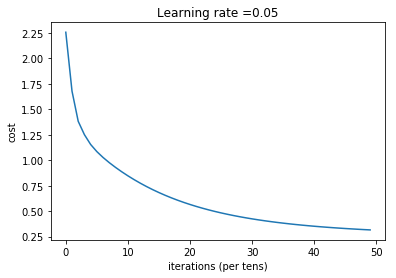

In [618]:
# ## define the network here
layer_dims = [n_x,40,40,n_y]

params,AL = train(X_train, Y_train, layer_dims, print_cost=True,num_iterations = 2500,learning_rate=0.05)

In [619]:
np.argmax(AL,axis=0)

array([6, 9, 1, 4], dtype=int64)

In [620]:
Y_train

array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [604]:
AL

array([[3.26170640e-13, 1.69267658e-13, 2.06718848e-13, 6.86360893e-13],
       [1.61648498e-01, 2.06914964e-01, 4.40978602e-01, 1.67331454e-01],
       [3.24558179e-13, 1.68323273e-13, 2.06327336e-13, 6.83928028e-13],
       [3.25583195e-13, 1.69014433e-13, 2.07041316e-13, 6.85520927e-13],
       [2.63342547e-01, 2.10843510e-01, 1.62604441e-01, 3.11565997e-01],
       [3.23547040e-13, 1.67551230e-13, 2.05990907e-13, 6.81973467e-13],
       [3.16615442e-01, 2.55099573e-01, 1.71873576e-01, 2.87746049e-01],
       [3.26879470e-13, 1.69980660e-13, 2.08305780e-13, 6.87610636e-13],
       [3.24893622e-13, 1.68825085e-13, 2.06656612e-13, 6.84698450e-13],
       [2.58393513e-01, 3.27141953e-01, 2.24543382e-01, 2.33356500e-01]])